In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns

# Function to split data into stratified chunks
def stratified_chunks(df, class_col, chunk_size):
    unique_classes = df[class_col].unique()
    samples_per_class = df[class_col].value_counts().min()
    num_chunks = samples_per_class // (chunk_size // len(unique_classes))
    chunks = []
    
    for i in range(num_chunks):
        chunk = pd.concat([
            df[df[class_col] == cls].iloc[i * (chunk_size // len(unique_classes)):(i + 1) * (chunk_size // len(unique_classes))]
            for cls in unique_classes
        ])
        chunks.append(chunk)
    
    return chunks

cola_results = pd.read_csv('Results/cola_results.csv')
mnli_results = pd.read_csv('Results/mnli_results.csv')
mrpc_results = pd.read_csv('Results/mrpc_results.csv')
sst2_results = pd.read_csv('Results/sst2_results.csv')

expected_responses_cola = ['acceptable', 'unacceptable']
expected_responses_sst2 = ['positive', 'negative']
expected_responses_mrpc = ['paraphrase', 'not paraphrase']
expected_responses_mnli = ['entailment', 'neutral', 'contradiction']

# Define mapping from string to numerical labels
label_mapping_cola = {'acceptable': 1, 'unacceptable': 0}
label_mapping_sst2 = {'positive': 1, 'negative': 0}
label_mapping_mrpc = {'paraphrase': 1, 'not paraphrase': 0}
label_mapping_mnli = {'entailment': 0, 'neutral': 1, 'contradiction': 2}

# Function to invert labels for SST-2 if incorrect
def invert_sst2_label(label, actual_label):
    if label in expected_responses_sst2:
        return label_mapping_sst2[label]
    else:
        return 1 - actual_label  # Opposite label (0 -> 1, 1 -> 0)
    

# Convert predicted labels to numerical and handle incorrect responses
cola_results['predicted_label'] = cola_results['predicted_label'].apply(lambda x: label_mapping_cola[x] if x in expected_responses_cola else -1)

# Identify incorrect predictions and invert them
sst2_results['predicted_label'] = sst2_results.apply(lambda row: label_mapping_sst2[row['predicted_label']] if row['predicted_label'] in expected_responses_sst2 else 1 - row['actual_label'], axis=1)

mrpc_results['predicted_label'] = mrpc_results['predicted_label'].apply(lambda x: label_mapping_mrpc[x] if x in expected_responses_mrpc else -1)

mnli_results['predicted_label'] = mnli_results['predicted_label'].apply(lambda x: label_mapping_mnli[x] if x in expected_responses_mnli else -1)

# Load the datasets
datasets = {
    'CoLA': cola_results,
    'SST-2': sst2_results,
    'MRPC': mrpc_results,
    'MNLI': mnli_results
}

# Define the actual label column name for each dataset
class_columns = {
    'CoLA': 'actual_label',
    'SST-2': 'actual_label',
    'MRPC': 'actual_label',
    'MNLI': 'actual_label'
}

# Split the datasets into chunks
chunks = {}
for task, df in datasets.items():
    chunks[task] = stratified_chunks(df, class_columns[task], 60)

# Save chunks to files
for task, task_chunks in chunks.items():
    print(task_chunks[0]['actual_label'].count())
    break

60


In [16]:
import matplotlib.pyplot as plt

# Function to plot class distribution
def plot_class_distribution(task, task_chunks, class_col):
    for i, chunk in enumerate(task_chunks):
        class_counts = chunk[class_col].value_counts()
        class_counts.plot(kind='bar')
        plt.title(f'{task} - Chunk {i + 1} Class Distribution')
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.show()

# Plot class distribution for each task
for task, task_chunks in chunks.items():
    #plot_class_distribution(task, task_chunks, class_columns[task])
    break
    print(task_chunks[0])
    break
for task in chunks:
    print(f"{task} first chunk sample:")
    print(chunks[task][0].head())
    print()

CoLA first chunk sample:
                                            sentence  actual_label  \
0          To the washroom kissed the Blarney stone.             0   
1  Mary claimed that intelligent, I consider Holl...             0   
2                  The boys were made a good mother.             0   
3  Clearly, John immediately will probably learn ...             0   
4       Stephen is believed to be easy to annoy Ben.             0   

   predicted_label  
0                0  
1                0  
2                0  
3                0  
4                0  

SST-2 first chunk sample:
                                            sentence  actual_label  \
0                                      unpleasantly              0   
1  create a ruffle in what is already an erratic ...             0   
2  each one of these people stand out and everybo...             0   
3                                      toilet-humor              0   
4  will find little of interest in this film , wh..

In [17]:
# Function to calculate metrics for each chunk
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# Dictionary to store metrics for each task
metrics = {'CoLA': [], 'SST-2': [], 'MRPC': [], 'MNLI': []}
tasks = ['CoLA', 'SST-2', 'MRPC', 'MNLI']

# Define the actual and predicted label columns
class_columns = {
    'CoLA': 'actual_label',
    'SST-2': 'actual_label',
    'MRPC': 'actual_label',
    'MNLI': 'actual_label'
}

predicted_columns = {
    'CoLA': 'predicted_label',
    'SST-2': 'predicted_label',
    'MRPC': 'predicted_label',
    'MNLI': 'predicted_label'
}

# Calculate metrics for each chunk
for task in chunks:
    for chunk in chunks[task]:
        y_true = chunk[class_columns[task]]
        y_pred = chunk[predicted_columns[task]]
        metrics[task].append(calculate_metrics(y_true, y_pred))

# Print metrics for verification
for task in tasks:
    print(f"Metrics for {task}:")
    for i, metric in enumerate(metrics[task]):
        print(f"Chunk {i + 1}: Accuracy = {metric[0]}, Precision = {metric[1]}, Recall = {metric[2]}, F1 = {metric[3]}")
    print()

Metrics for CoLA:
Chunk 1: Accuracy = 0.8666666666666667, Precision = 0.8733031674208145, Recall = 0.8666666666666667, F1 = 0.8660714285714285
Chunk 2: Accuracy = 0.7833333333333333, Precision = 0.8113553113553115, Recall = 0.7833333333333333, F1 = 0.7783461210571185
Chunk 3: Accuracy = 0.8333333333333334, Precision = 0.8588516746411483, Recall = 0.8333333333333334, F1 = 0.830316742081448
Chunk 4: Accuracy = 0.8333333333333334, Precision = 0.8333333333333334, Recall = 0.8333333333333334, F1 = 0.8333333333333334
Chunk 5: Accuracy = 0.8666666666666667, Precision = 0.8733031674208145, Recall = 0.8666666666666667, F1 = 0.8660714285714285
Chunk 6: Accuracy = 0.85, Precision = 0.86, Recall = 0.85, F1 = 0.8489510489510489
Chunk 7: Accuracy = 0.8, Precision = 0.8229665071770335, Recall = 0.8, F1 = 0.7963800904977375
Chunk 8: Accuracy = 0.8, Precision = 0.8054298642533937, Recall = 0.8, F1 = 0.7991071428571428
Chunk 9: Accuracy = 0.85, Precision = 0.8701527614571093, Recall = 0.85, F1 = 0.84793

/Users/micki/opt/anaconda3/envs/IntelligentSystems/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/micki/opt/anaconda3/envs/IntelligentSystems/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# Function to prepare DataFrame for ANOVA
def prepare_metrics_df(metrics_dict, metric_index):
    data = []
    for task, task_metrics in metrics_dict.items():
        for metric in task_metrics:
            data.append((task, metric[metric_index]))
    return pd.DataFrame(data, columns=['Task', 'Value'])

# Prepare DataFrame for each metric
accuracy_df = prepare_metrics_df(metrics, 0)
precision_df = prepare_metrics_df(metrics, 1)
recall_df = prepare_metrics_df(metrics, 2)
f1_df = prepare_metrics_df(metrics, 3)

# Print data frames for verification
# print(accuracy_df.head())
# print(precision_df.head())
# print(recall_df.head())
# print(f1_df.head())

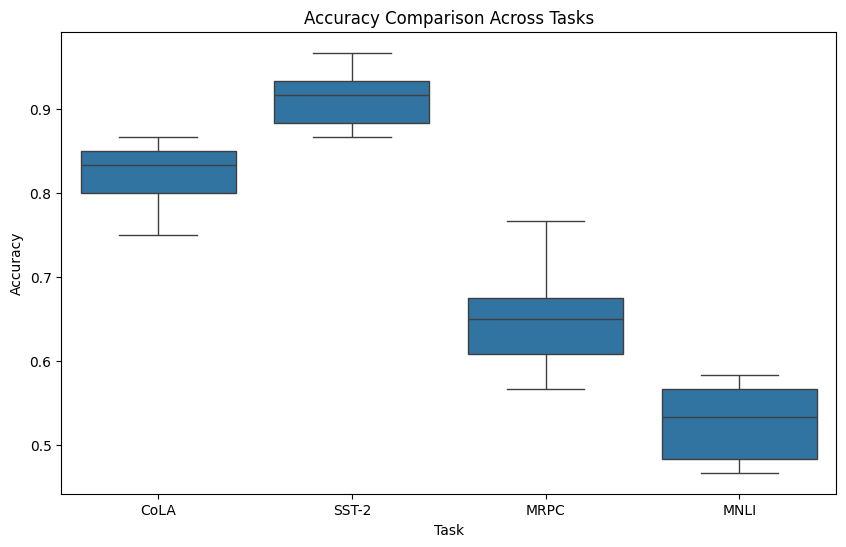

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot metrics
def plot_metrics(df, metric_name):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Task', y='Value', data=df)
    plt.title(f'{metric_name} Comparison Across Tasks')
    plt.xlabel('Task')
    plt.ylabel(metric_name)
    plt.show()

# Example: Plot accuracy distribution
plot_metrics(accuracy_df, 'Accuracy')

In [22]:
# Perform ANOVA for each metric
def perform_anova(df, metric_name):
    anova_result = f_oneway(
        df[df['Task'] == 'CoLA']['Value'],
        df[df['Task'] == 'SST-2']['Value'],
        df[df['Task'] == 'MRPC']['Value'],
        df[df['Task'] == 'MNLI']['Value']
    )
    print(f"ANOVA result for {metric_name}: F-statistic = {anova_result.statistic}, p-value = {anova_result.pvalue}")

# Perform ANOVA on each metric
perform_anova(accuracy_df, 'Accuracy')
perform_anova(precision_df, 'Precision')
perform_anova(recall_df, 'Recall')
perform_anova(f1_df, 'F1 Score')

ANOVA result for Accuracy: F-statistic = 223.8421227197344, p-value = 3.8239530882533484e-31
ANOVA result for Precision: F-statistic = 75.03504491115926, p-value = 1.307165702295515e-19
ANOVA result for Recall: F-statistic = 223.8421227197344, p-value = 3.8239530882533484e-31
ANOVA result for F1 Score: F-statistic = 274.0252702486416, p-value = 1.9876947900254326e-33


## First let's check the assumptions

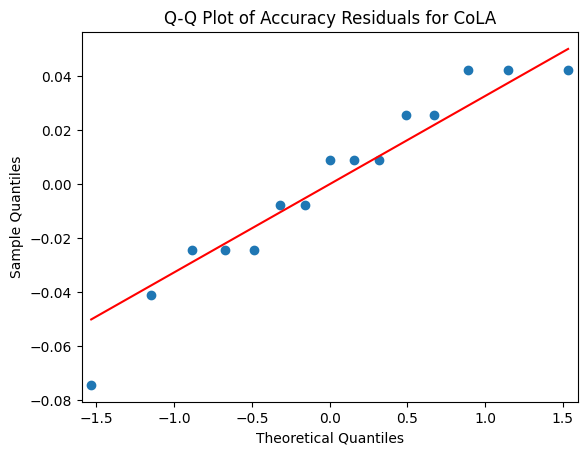

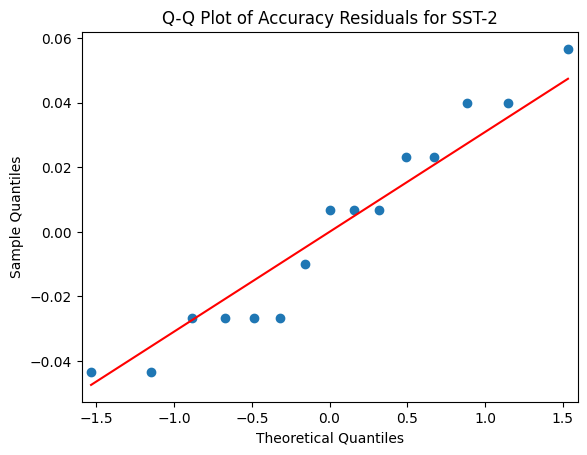

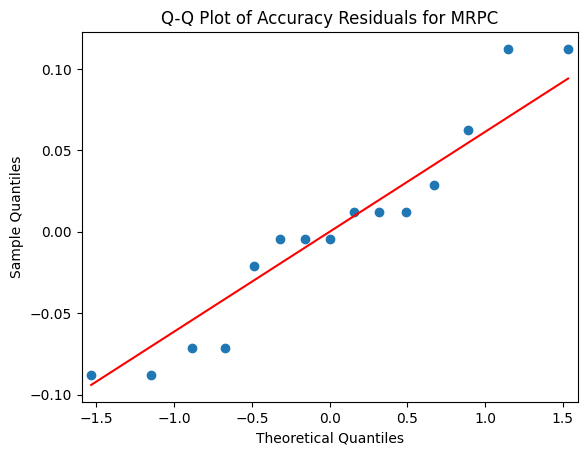

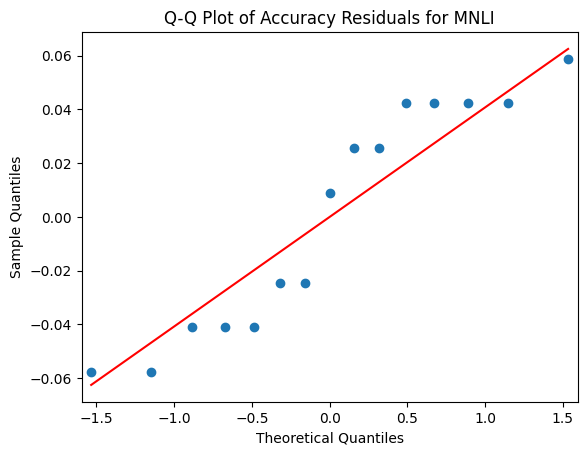

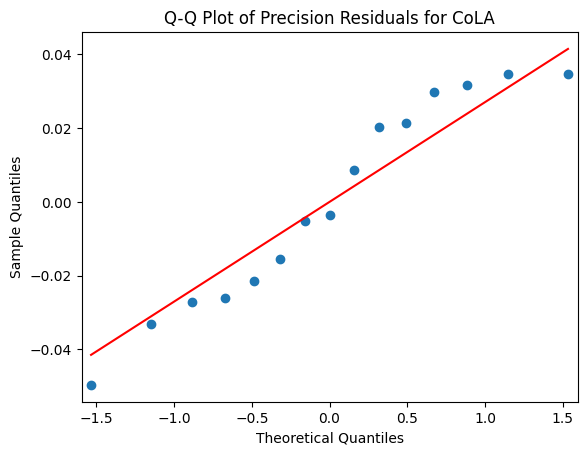

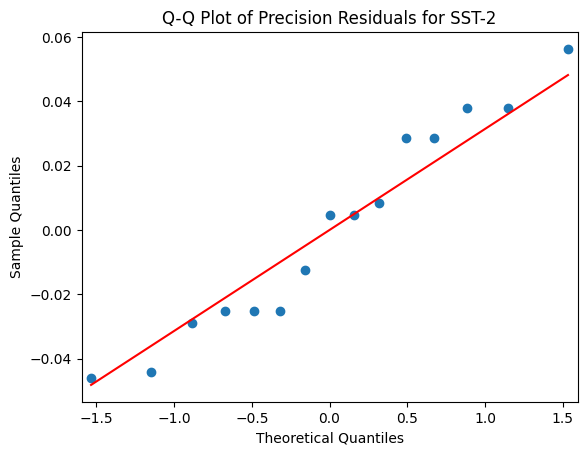

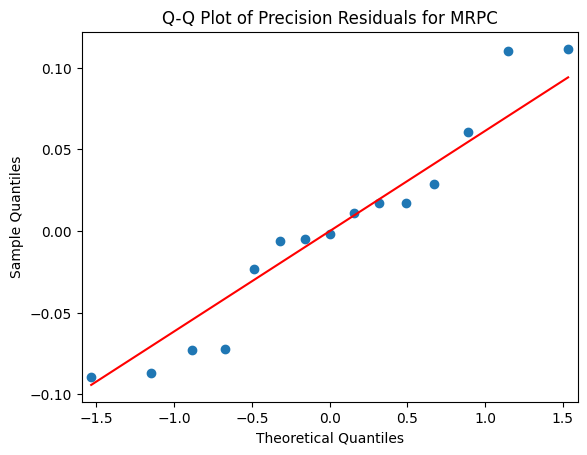

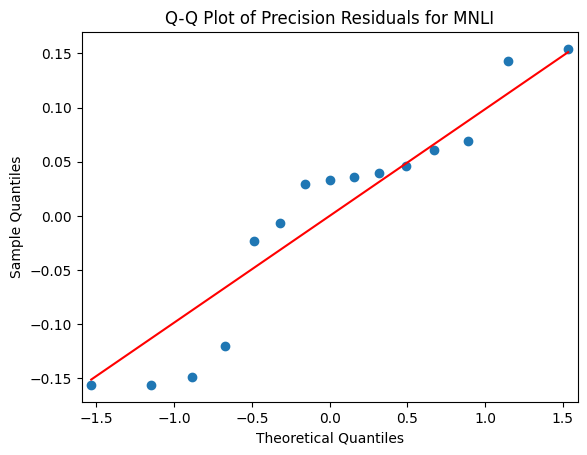

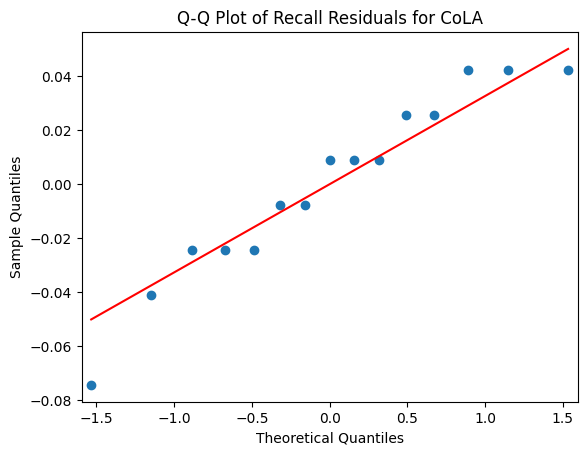

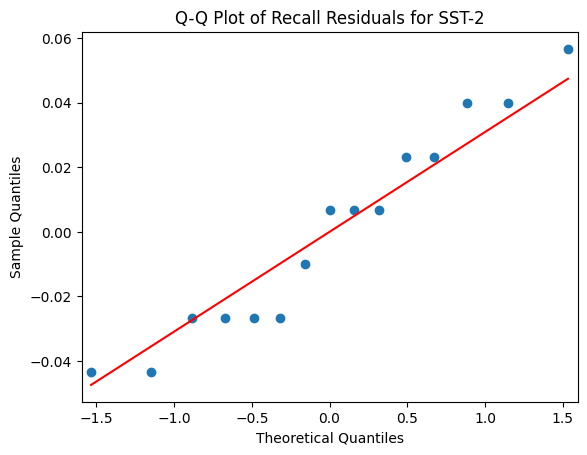

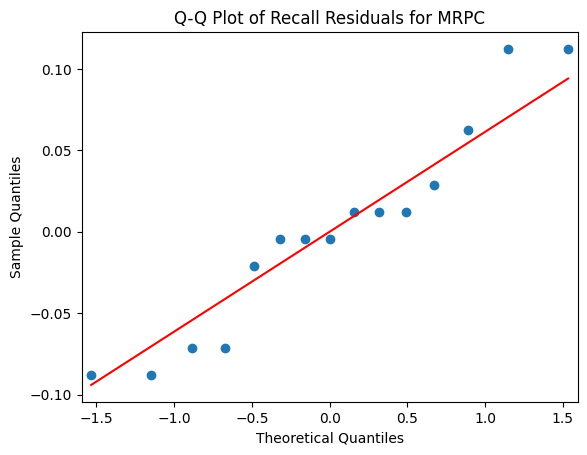

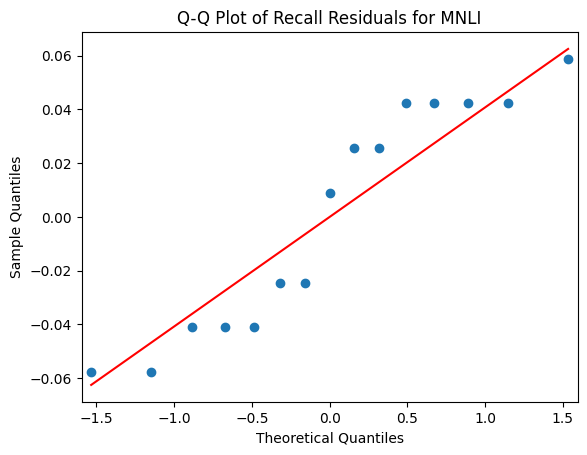

In [28]:
import statsmodels.api as sm
import seaborn as sns

def calculate_task_residuals(df):
    task_means = df.groupby('Task')['Value'].mean()
    df['Residuals'] = df.apply(lambda row: row['Value'] - task_means[row['Task']], axis=1)
    return df

# Calculate residuals for each metric DataFrame
accuracy_df = calculate_task_residuals(accuracy_df)
precision_df = calculate_task_residuals(precision_df)
recall_df = calculate_task_residuals(recall_df)
f1_df = calculate_task_residuals(f1_df)

# Function to generate Q-Q plots for each task
def generate_qq_plots(df, metric_name):
    tasks = df['Task'].unique()
    
    for task in tasks:
        task_data = df[df['Task'] == task]
        residuals = task_data['Residuals']
        
        # Generate Q-Q plot
        sm.qqplot(residuals, line='s')
        plt.title(f"Q-Q Plot of {metric_name} Residuals for {task}")
        plt.show()

# Generate Q-Q plots for each task and metric
generate_qq_plots(accuracy_df, 'Accuracy')
generate_qq_plots(precision_df, 'Precision')
generate_qq_plots(recall_df, 'Recall')


Homogeneity of variances check for Accuracy:


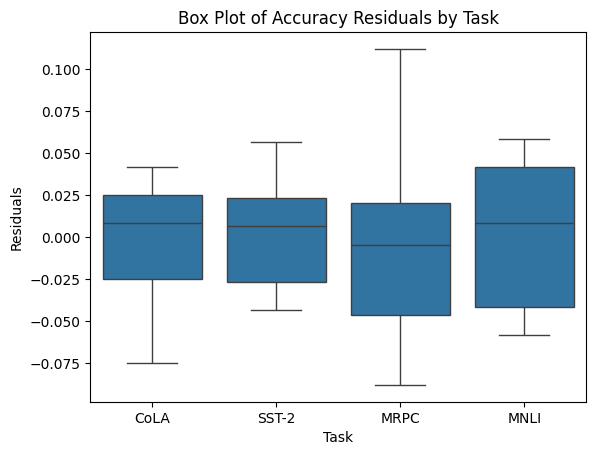


Homogeneity of variances check for Precision:


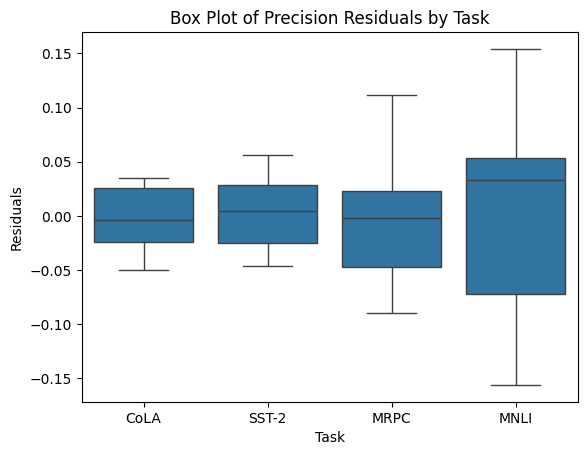


Homogeneity of variances check for Recall:


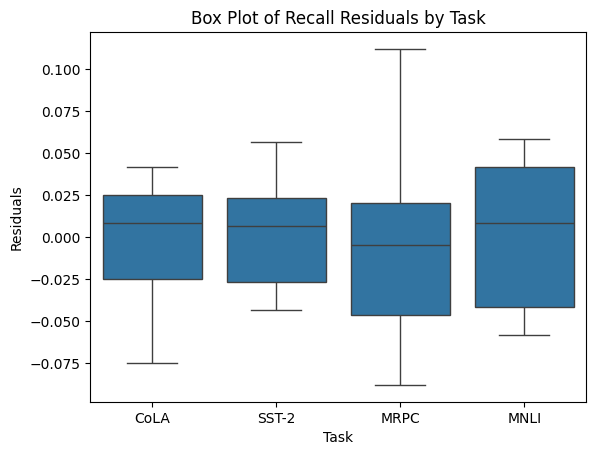

In [29]:
def check_homogeneity(df, metric_name):
    print(f"\nHomogeneity of variances check for {metric_name}:")
    
    # Box plot
    sns.boxplot(x='Task', y='Residuals', data=df)
    plt.title(f"Box Plot of {metric_name} Residuals by Task")
    plt.show()

check_homogeneity(accuracy_df, 'Accuracy')
check_homogeneity(precision_df, 'Precision')
check_homogeneity(recall_df, 'Recall')

# POST HOC

Tukey HSD results for Accuracy:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
  CoLA   MNLI     -0.3   0.0 -0.3432 -0.2568   True
  CoLA   MRPC    -0.17   0.0 -0.2132 -0.1268   True
  CoLA  SST-2   0.0856   0.0  0.0424  0.1287   True
  MNLI   MRPC     0.13   0.0  0.0868  0.1732   True
  MNLI  SST-2   0.3856   0.0  0.3424  0.4287   True
  MRPC  SST-2   0.2556   0.0  0.2124  0.2987   True
---------------------------------------------------
Tukey HSD results for Precision:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  CoLA   MNLI  -0.2232    0.0 -0.2849 -0.1615   True
  CoLA   MRPC  -0.1822    0.0 -0.2439 -0.1205   True
  CoLA  SST-2    0.074 0.0126  0.0123  0.1357   True
  MNLI   MRPC    0.041 0.3028 -0.0207  0.1027  False
  MNLI  SST-2   0.2972    0.0  0.2355  0.3

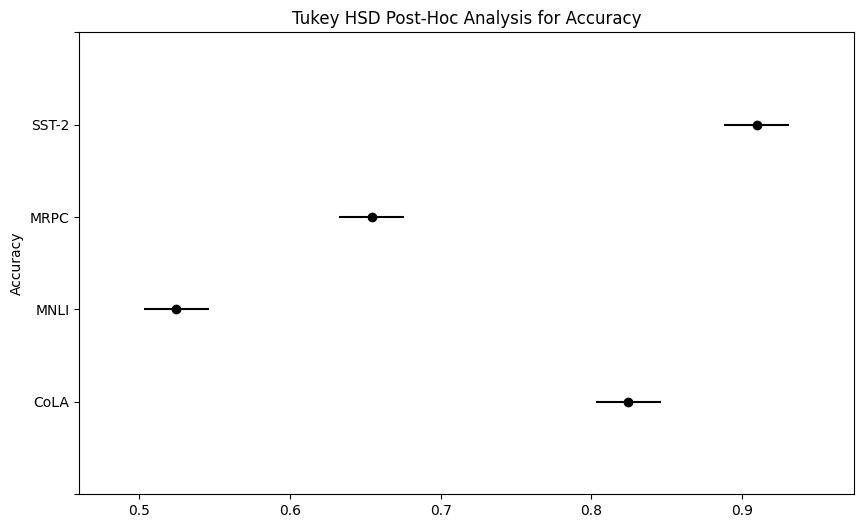

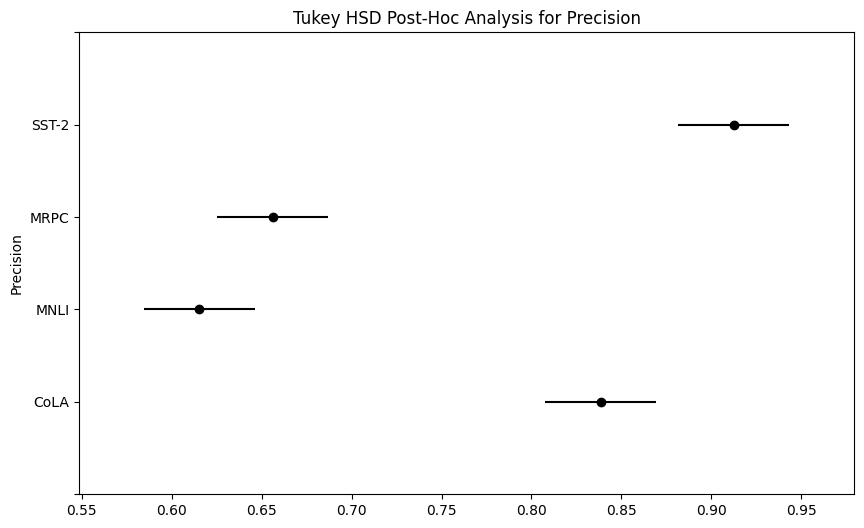

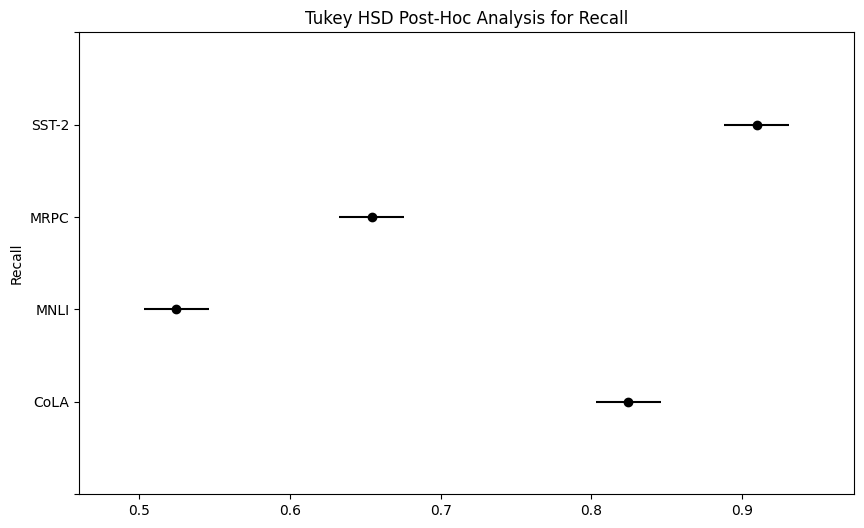

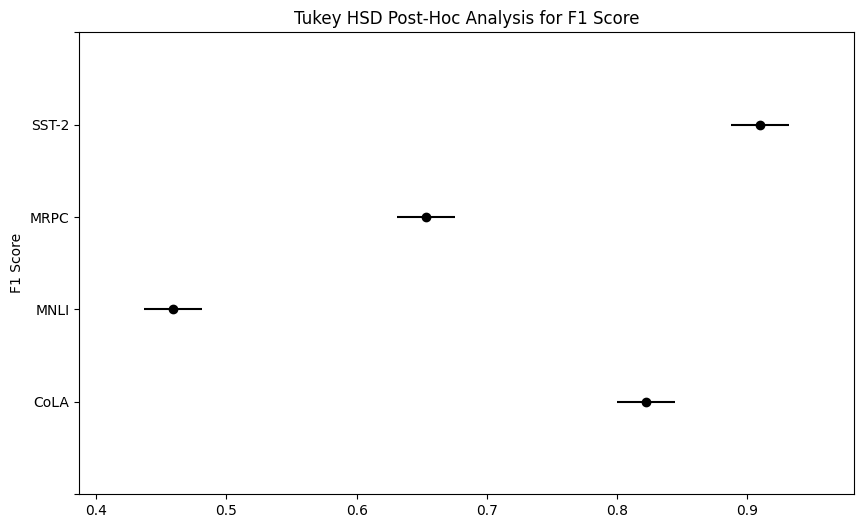

In [24]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Function to perform Tukey's HSD test
def tukey_hsd_test(df, metric_name):
    tukey_result = pairwise_tukeyhsd(endog=df['Value'], groups=df['Task'], alpha=0.05)
    print(f"Tukey HSD results for {metric_name}:\n", tukey_result)
    return tukey_result

# Perform Tukey's HSD test on each metric
tukey_accuracy = tukey_hsd_test(accuracy_df, 'Accuracy')
tukey_precision = tukey_hsd_test(precision_df, 'Precision')
tukey_recall = tukey_hsd_test(recall_df, 'Recall')
tukey_f1 = tukey_hsd_test(f1_df, 'F1 Score')

def plot_tukey_hsd(tukey_result, metric_name):
    tukey_result.plot_simultaneous(ylabel=metric_name)
    plt.title(f'Tukey HSD Post-Hoc Analysis for {metric_name}')
    plt.show()

# Plot results
plot_tukey_hsd(tukey_accuracy, 'Accuracy')
plot_tukey_hsd(tukey_precision, 'Precision')
plot_tukey_hsd(tukey_recall, 'Recall')
plot_tukey_hsd(tukey_f1, 'F1 Score')

In [25]:
tukey_accuracy